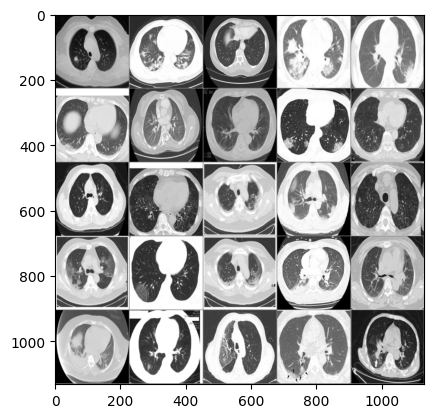

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
num_epochs = 100
batch_size = 100
learning_rate = 0.001

# Define a custom transformation to convert RGB to grayscale
class RGBtoGray:
    def __call__(self, img):
        # Convert the PIL Image to grayscale
        gray_img = img.convert('L')
        return gray_img

# transform
transform = transforms.Compose(
    [RGBtoGray(),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

train_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/train data', transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/test data', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

classes = ('CT_COVID', 'CT_NonCOVID')

def imshow(imgs):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))  
    plt.show()

# one batch of random training images
# Iterate through the batches in the DataLoader
for images, labels in train_loader:
    img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
    imshow(img_grid)
    break  # Display images from the first batch and then exit the loop


In [3]:
print(device)

cpu


In [8]:
torch.cuda.is_available()

False

In [9]:
# update cuda 


In [10]:
from tqdm.notebook import tqdm

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.fc1 = nn.Linear(in_features=1024*1*1, out_features=512)
        
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=2)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        # print(out.shape)
        out = self.dropout(out)
        out = self.fc2(out)
        # print(out.shape)
        out = self.dropout(out)
        out = self.fc3(out)
        # print(out.shape)
        return out
    
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

# Initialize lists to store the training and test history
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Testing loop (to calculate test loss and accuracy)
    model.eval()  # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate test accuracy and loss
    test_accuracy = 100 * correct_test / total_test
    test_loss = test_running_loss / len(test_loader)

    # Append to the history lists
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')
path = './cnn.pth'
torch.save(model.state_dict(), path)


Epoch 1/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.1650, Train Accuracy: 54.52%, Test Loss: 2.6097, Test Accuracy: 47.30%


Epoch 2/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.8473, Train Accuracy: 63.71%, Test Loss: 3.6954, Test Accuracy: 49.32%


Epoch 3/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.8142, Train Accuracy: 61.54%, Test Loss: 0.8326, Test Accuracy: 60.81%


Epoch 4/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.6365, Train Accuracy: 69.06%, Test Loss: 0.6280, Test Accuracy: 68.24%


Epoch 5/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.6283, Train Accuracy: 71.91%, Test Loss: 0.7629, Test Accuracy: 64.86%


Epoch 6/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.5623, Train Accuracy: 71.91%, Test Loss: 0.7275, Test Accuracy: 57.43%


Epoch 7/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.4742, Train Accuracy: 77.76%, Test Loss: 0.7990, Test Accuracy: 61.49%


Epoch 8/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.4371, Train Accuracy: 79.77%, Test Loss: 0.7829, Test Accuracy: 64.19%


Epoch 9/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.3668, Train Accuracy: 84.78%, Test Loss: 0.7178, Test Accuracy: 72.30%


Epoch 10/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.3134, Train Accuracy: 84.95%, Test Loss: 0.7529, Test Accuracy: 76.35%


Epoch 11/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.2863, Train Accuracy: 88.46%, Test Loss: 0.8285, Test Accuracy: 66.22%


Epoch 12/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.2690, Train Accuracy: 88.96%, Test Loss: 1.6390, Test Accuracy: 62.16%


Epoch 13/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.2773, Train Accuracy: 87.96%, Test Loss: 0.9844, Test Accuracy: 77.03%


Epoch 14/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.3126, Train Accuracy: 85.95%, Test Loss: 0.3992, Test Accuracy: 79.73%


Epoch 15/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.2120, Train Accuracy: 92.14%, Test Loss: 1.2202, Test Accuracy: 71.62%


Epoch 16/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.1446, Train Accuracy: 94.48%, Test Loss: 0.6237, Test Accuracy: 81.76%


Epoch 17/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.1073, Train Accuracy: 95.65%, Test Loss: 0.5420, Test Accuracy: 81.08%


Epoch 18/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.0914, Train Accuracy: 96.82%, Test Loss: 0.7089, Test Accuracy: 83.11%


Epoch 19/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.0794, Train Accuracy: 96.82%, Test Loss: 0.8763, Test Accuracy: 79.05%


Epoch 20/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.0786, Train Accuracy: 96.82%, Test Loss: 3.8314, Test Accuracy: 60.14%


Epoch 21/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.1086, Train Accuracy: 95.32%, Test Loss: 2.6743, Test Accuracy: 66.89%


Epoch 22/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.0981, Train Accuracy: 96.66%, Test Loss: 0.8889, Test Accuracy: 77.70%


Epoch 23/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.0436, Train Accuracy: 98.33%, Test Loss: 0.9128, Test Accuracy: 79.73%


Epoch 24/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.0350, Train Accuracy: 98.33%, Test Loss: 0.8508, Test Accuracy: 79.73%


Epoch 25/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.0253, Train Accuracy: 99.16%, Test Loss: 0.7717, Test Accuracy: 81.76%


Epoch 26/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.0203, Train Accuracy: 99.50%, Test Loss: 1.1206, Test Accuracy: 77.03%


Epoch 27/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.0447, Train Accuracy: 98.16%, Test Loss: 0.8607, Test Accuracy: 79.73%


Epoch 28/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.0500, Train Accuracy: 98.49%, Test Loss: 1.1637, Test Accuracy: 82.43%


Epoch 29/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.0344, Train Accuracy: 98.83%, Test Loss: 0.6511, Test Accuracy: 87.16%


Epoch 30/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.0298, Train Accuracy: 98.83%, Test Loss: 0.9509, Test Accuracy: 84.46%


Epoch 31/100:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.0100, Train Accuracy: 99.67%, Test Loss: 0.7417, Test Accuracy: 83.11%


Epoch 32/100:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    n_correct=0
    n_samples=len(test_loader.dataset)
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs=model(images)
        
        # value, index
        _, predictions=torch.max(outputs, 1)
        n_correct+=(predictions==labels).sum().item()
    
    acc=100.0*n_correct/n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(test_loss_history, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', marker='o')
plt.plot(test_accuracy_history, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()
